<a href="https://colab.research.google.com/github/mconnors55/Titanic-Data-Analysis/blob/main/Titanic_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.tree import plot_tree

from sklearn.linear_model import LogisticRegression

!pip install treeviz
!pip install xgboost
!pip install shap

import treeviz

import xgboost
import shap

url = 'https://raw.githubusercontent.com/mconnors55/csc310data/refs/heads/main/train.csv'

df = pd.read_csv(url).drop('PassengerId', axis=1)

df.head()

  Preparing metadata (setup.py) ... done
  Created wheel for treeviz: filename=treeviz-1.1-py3-none-any.whl size=3319 sha256=65257b8c5ee1ae34e49ebbfad2dee75acd414e794db4e2fe966f4e42dde8edd4
  Stored in directory: /root/.cache/pip/wheels/c1/4f/48/17625800a9016d78b60284a5442982c5f7c0656d634843501a
Successfully built treeviz


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The project that I have done is the Individual	Project:	Data	Analysis	and	Modeling.

The data set that I will be using is called the "Titanic Dataset", and I downloaded it from Kaggle.  The dataset has 12 columns; 10 features and 1 target, with an additional "Passenger ID" column.  

The target variable is "Survived", which describes whether an individual passenger survived the sinking of the Titanic, and its data type is integer, with 1 representing that the passenger survived, and 0 representing that they did not.  

"Pclass" is an integer feature which describes which type of ticket the passenger had; first, second, or third class.  "Name", "Sex", and "Age" are self explanatory, with string, string, and integer values respectively.  "SibSp" is an integer column which holds the number of the passenger's sibling that were also on board.  "Parch" is also an integer column, which holds the number of the passenger's parents or children that were on board.  "Ticket" is a string feature that records the passenger's ticket number, "Fare" is an integer feature that records the cost of the ticket, "Cabin" is a string feature that records the passenger's cabin number, and "Embarked" is a string feature that records which port the passenger departed from.

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687


According to a null check, Age has 177 missing values, Cabin has 687 missing values, and Embarked has 2 missing values.  Because there are only 891 columns, and 86 "Age" values missing, it is important to use data imputation, specifically K-Nearest-Neighbors, in order to ensure the most accurate analysis.  Cabin is missing values for more than half of the entries, so it makes the most sense to drop the Cabin column altogether.  Finally, because there are only 2, we can drop the rows missing an "Embarked" value.

In [ ]:
#I used some of the code included in the Week 4 lesson in order to perform this KNN data imputation

df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

age = df['Age']

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

age_cleaned = imputer.fit_transform(df[['Age']])

age_cleaned = pd.DataFrame(age_cleaned, columns= ['Age'])

df.drop('Age', axis=1, inplace=True)

df = pd.concat([df.loc[ : ,'Survived': 'Embarked'],age_cleaned ], axis=1)
df.head()

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age
0,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,NaN,S,22.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C85,C,38.0
2,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,C123,S,35.0
4,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,NaN,S,35.0


In [ ]:
df.drop('Cabin', axis=1, inplace=True)
df = df.dropna()
df.isnull().sum()

,0
Survived,0
Pclass,0
Name,0
Sex,0
SibSp,0
Parch,0
Ticket,0
Fare,0
Embarked,0
Age,0


Because we will be performing classification on this data set, it is important to be particular about which features we use.  "Name" and "Ticket" are both unhelpful, because they have a unique value for each entry in the table.  This means that keeping them as features could lead to overfitting, so we must remove them.

In [ ]:
df = df.drop(['Name', 'Ticket'], axis=1)
df.head()


df_features = df.drop('Survived', axis=1)
df_target = df['Survived']

In [ ]:
def classification_confint(acc, n):
    '''
    Compute the 95% confidence interval for a classification problem.
      acc -- classification accuracy
      n   -- number of observations used to compute the accuracy
    Returns a tuple (lb,ub)
    '''
    import math
    interval = 1.96*math.sqrt(acc*(1-acc)/n)
    lb = max(0, acc - interval)
    ub = min(1.0, acc + interval)
    return (lb,ub)

**Exploratory Analysis**

In [ ]:
df.describe()

,Survived,Pclass,SibSp,Parch,Fare,Age
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,0.524184,0.382452,32.096681,29.653446
std,0.486260,0.834700,1.103705,0.806761,49.697504,12.968366
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.420000
25%,0.000000,2.000000,0.000000,0.000000,7.895800,22.000000
50%,0.000000,3.000000,0.000000,0.000000,14.454200,29.699118
75%,1.000000,3.000000,1.000000,0.000000,31.000000,35.000000
max,1.000000,3.000000,8.000000,6.000000,512.329200,80.000000


Because the target variable described is binary, we are able to measure how balanced the data is based on its mean.  As shown above, the mean value of "Survived" is 0.382, which means that the data is slightly biased towards non-survivors.  This can be better visualized with the below pie chart, which shows the difference in frequency between the two target values.

<Axes: ylabel='count'>

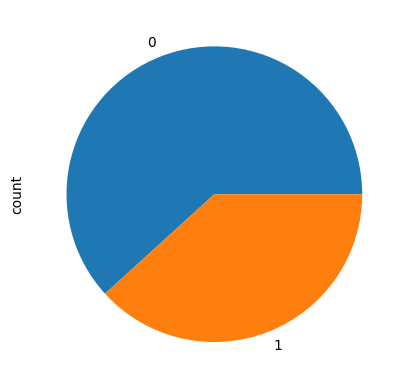

In [ ]:
plot_series = df['Survived']
plot_series.name = ''
plot_series.value_counts().plot(kind='pie')

array([[<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'Age'}>, <Axes: >]], dtype=object)

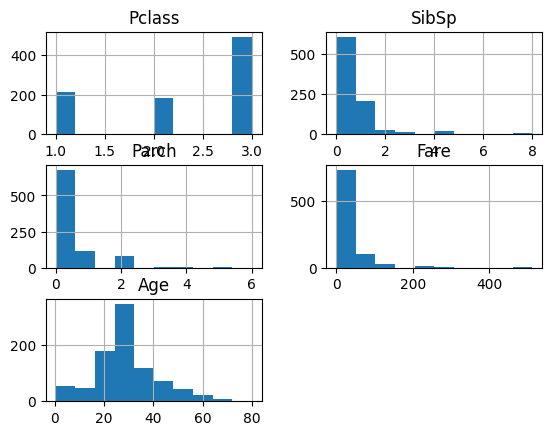

In [ ]:
df_features.hist()

Above are histograms for every numerical feature in the dataset.

The histogram for "PClass" shows that there are a lot more third-class passengers in the dataset than there are first or second, which could mean that the model we build is more accurate for passengers of a lower socioeconomic status.

The histogram for "SibSp" shows that the passengers in the dataset tend to have a low amount of siblings also on board, with over 500 having between 0 and 1.

The histogram for "Parch" shows a similar trend to that of "SibSp", where passengers tend to have very few parents or children also on board the ship, with even more having between 0 and 1.

The histogram for "Fare" shows that most tickets tended to be around the same cost, however there are a few outliers which are much higher than the rest.  This also suggests that a model we build could be more accurate for passengers of a lower socioeconomic status.

The histogram for "Age" shows that there is a wide range of passenger ages in the dataset, which seem to be approximately normally distributed between 0 and 70 years old.

In terms of the qualitative

<Axes: ylabel='count'>

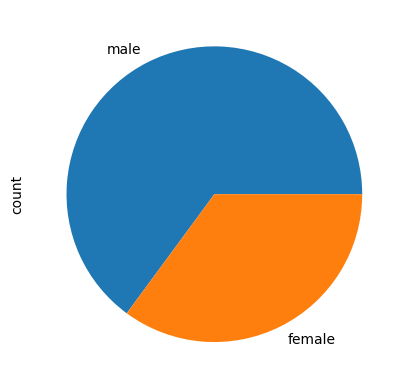

In [ ]:
plot_series = df['Sex']
plot_series.name = ''
plot_series.value_counts().plot(kind='pie')

Based on the above pie chart, there are a lot more male passengers in the dataset than there are female.

<Axes: ylabel='count'>

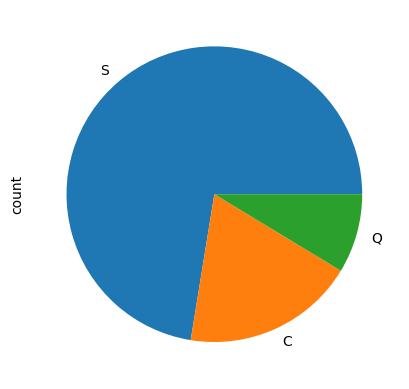

In [ ]:
plot_series = df['Embarked']
plot_series.name = ''
plot_series.value_counts().plot(kind='pie')

Based on the above pie chart, most of the passengers boarded the Titanic at Southampton, with an almost equal amount of passengers boarding at Cherbourg and Queenstown.

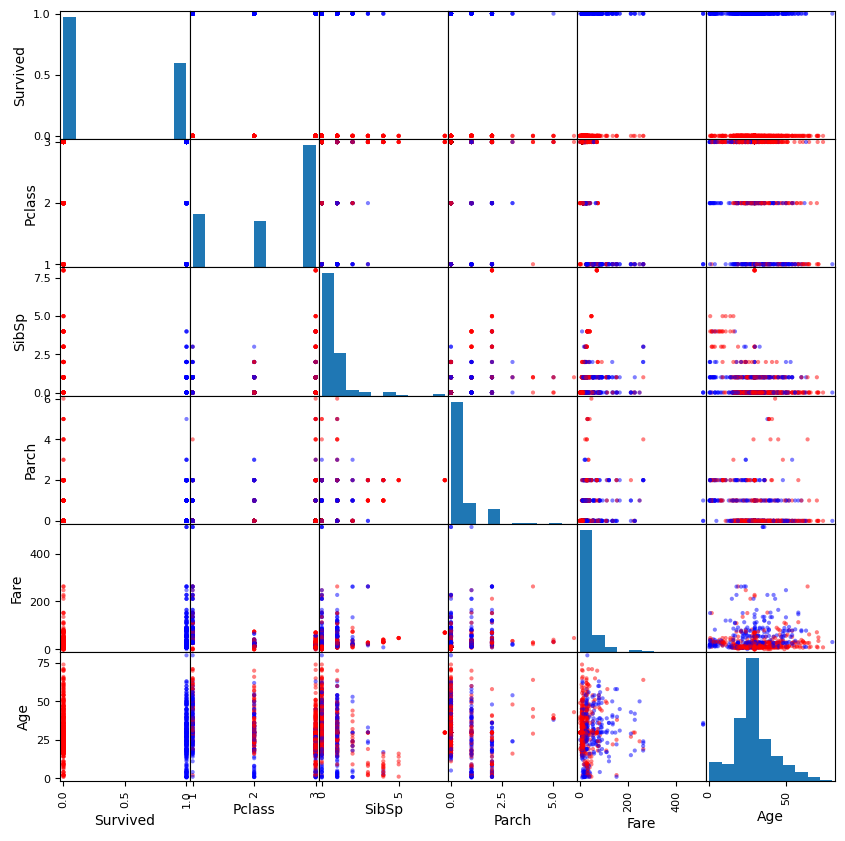

In [ ]:
def fn_color(x):
  if x == 0:
    return 'red'
  elif x == 1:
    return 'blue'

# compute a color vector
color_vector = df['Survived'].map(fn_color)

# use the color vector in the plot
null = pd.plotting.scatter_matrix(df, figsize=[10,10],c=color_vector)

Aside from the insights we gained from the other graphs, there a couple inferences that can be made from this scatter matrix.  First, there seems to be a pretty strong correlation between higher "Fare" and survival.  The blue dots represent survivors, and the red dots represent non-survivors.  This trend is especially visible in the Age vs. Fare subplot.  Additionally, there is a mild association between lower "Parch" and a higher rate of survival, as can be seen in the Parch vs. Age subplot.

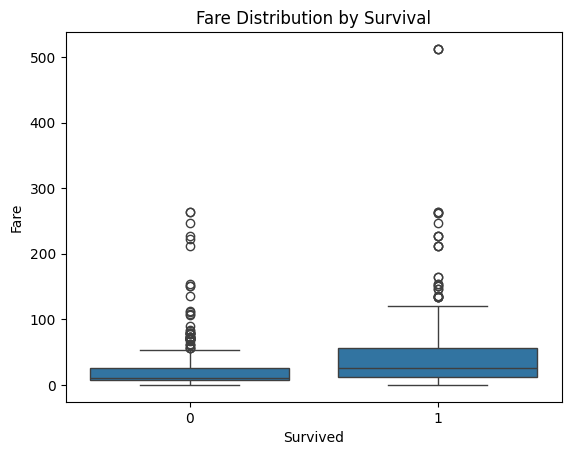

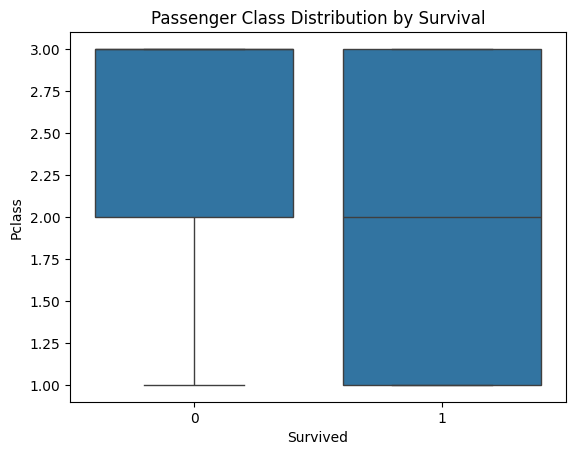

In [ ]:
#I am using the box plots discussed in the Seaborn notebook from week 5

sns.boxplot(x='Survived', y='Fare', data=df)
plt.title("Fare Distribution by Survival")
plt.show()

sns.boxplot(x='Survived', y='Pclass', data=df)
plt.title("Passenger Class Distribution by Survival")
plt.show()

The first box plot reinforces the first inference we made, that the passengers who survived tended to have spent a higher fare on their ticket.

The second box plot shows that passengers who survived tended to be in a higher class.

Based on all of the data visualization, my hypothesis is that "Passenger Class" and "Fare" are the two variables which will have the greatest impact on whether or not a passenger survived or not.  

In [ ]:
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age
0,0,3,male,1,0,7.2500,S,22.0
1,1,1,female,1,0,71.2833,C,38.0
2,1,3,female,0,0,7.9250,S,26.0
3,1,1,female,1,0,53.1000,S,35.0
4,0,3,male,0,0,8.0500,S,35.0


**Predictive Analysis**

In [ ]:
df_mlp = df_features.replace('female', 0)
df_mlp = df_mlp.replace('male', 1)
df_mlp = df_mlp.replace('S', 0)
df_mlp = df_mlp.replace('C', 1)
df_mlp = df_mlp.replace('Q', 2)

X  = df_mlp
y = df_target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=3)

<ipython-input-16-f2983ca24d4c>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mlp = df_mlp.replace('male', 1)
<ipython-input-16-f2983ca24d4c>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mlp = df_mlp.replace('Q', 2)


**Decision Tree**

Below is a grid search to determine the best parameters for a decision tree model on the data set.  According to the grid search, the best parameters are a criterion of 'gini' and a max_depth of 4.  Using these parameters, the model has a mean accuracy of 0.83, with a 95% chance that the true accuracy of the model lies between 0.77 and 0.88.

In [ ]:
cv = KFold(n_splits=5,  shuffle = True)

# setting up grid search
model = tree.DecisionTreeClassifier()
param_grid = {
    'max_depth': list(range(1,11)), # search 1..10
    'criterion': ['entropy', 'gini']
    }
grid = GridSearchCV(model, param_grid, cv=5)

# performing grid search
grid.fit(X_train, y_train)

# print out what we found
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'criterion': 'gini', 'max_depth': 4}


In [ ]:
model_dtree = tree.DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)

model_dtree.fit(X_train, y_train)

pred_test_dtree = model_dtree.predict(X_test)

acc_dtree = accuracy_score(y_test, pred_test_dtree)
bal_acc_dtree = balanced_accuracy_score(y_test, pred_test_dtree)
prec_dtree = precision_score(y_test, pred_test_dtree, average='weighted')
rec_dtree = recall_score(y_test, pred_test_dtree, average='weighted')

observations = X_test.shape[0]

# 95% confidence interval
lb,ub = classification_confint(acc_dtree, observations)
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc_dtree,lb,ub))
print("Balanced Accuracy: {:3.2f}".format(bal_acc_dtree))
print("Precision: {:3.2f}".format(prec_dtree))
print("Recall: {:3.2f}".format(rec_dtree))

Accuracy: 0.83 (0.77,0.88)
Balanced Accuracy: 0.79
Precision: 0.83
Recall: 0.83


**MLP Classifier**

Below is a grid search across multiple depths and activation parameters for an MLP Classifier model.  The best parameters are {'activation': 'tanh', 'hidden_layer_sizes': (19,)}, and the mean accuracy of the model with these parameters is 0.68, with a 95% chance that the true accuracy lies between 0.65 and 0.71.

In [ ]:
model = MLPClassifier(max_iter=10000, random_state=1)
param_grid = {
    'hidden_layer_sizes': [(i,) for i in range(10, 21)],
    'activation': ['logistic', 'tanh', 'relu']
}

grid = GridSearchCV(model, param_grid, cv=3)
grid.fit(X, y)
print("Grid Search: best parameters: {}".format(grid.best_params_))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Grid Search: best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (19,)}


In [ ]:
best_model_mlp = grid.best_estimator_
predict_y_mlp = best_model_mlp.predict(X_test)

acc_mlp = accuracy_score(y_test, predict_y_mlp)
bal_acc_mlp = balanced_accuracy_score(y_test, predict_y_mlp)
prec_mlp = precision_score(y_test, predict_y_mlp, average='weighted')
rec_mlp = recall_score(y_test, predict_y_mlp, average='weighted')

lb,ub = classification_confint(acc_mlp,X.shape[0])

print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc_mlp,lb,ub))
print("Balanced Accuracy: {:3.2f}".format(bal_acc_mlp))
print("Precision: {:3.2f}".format(prec_mlp))
print("Recall: {:3.2f}".format(rec_mlp))

Accuracy: 0.68 (0.65,0.71)
Balanced Accuracy: 0.65
Precision: 0.67
Recall: 0.68


**K-Nearest Neighbors**

Below is a grid search across a variety of different values for n in a K-Nearest-Neighbors model.  A KNN model works by taking a look at the 'k' closest datapoints to the point currently being classified, then gives it the value which has the largest representation among its neighbors.  The best parameter is {n=20}, which results in a mean accuracy of 0.68, with a 95% chance that the true accuracy of the model lies between 0.61 and 0.75.

In [ ]:
model = KNeighborsClassifier()

# do the 5-fold cross validation and shuffle the data
cv = KFold(n_splits=5,  shuffle = True)

# grid search
param_grid = {'n_neighbors': list(range(1,26))}
grid = GridSearchCV(model, param_grid, cv=cv)

# performing grid search
grid.fit(X_train, y_train)
print("Grid Search: best parameters: {}".format(grid.best_params_))

# accuracy of best model with confidence interval
pred_test_knn = grid.best_estimator_.predict(X_test)
acc_knn = accuracy_score(y_test, pred_test_knn)
bal_acc_knn = balanced_accuracy_score(y_test, pred_test_knn)
prec_knn = precision_score(y_test, pred_test_knn, average='weighted')
rec_knn = recall_score(y_test, pred_test_knn, average='weighted')


lb,ub = classification_confint(acc_knn,X_test.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc_knn,lb,ub))
print("Balanced Accuracy: {:3.2f}".format(bal_acc_knn))
print("Precision: {:3.2f}".format(prec_knn))
print("Recall: {:3.2f}".format(rec_knn))

Grid Search: best parameters: {'n_neighbors': 3}
Accuracy: 0.68 (0.61,0.75)
Balanced Accuracy: 0.65
Precision: 0.67
Recall: 0.68


**SVM**

Below is a grid search across a variety of different C values for a linear SVM model.  This model finds the plane which allows the greatest amount of separation between the two target values.  Changing the C value determines how important it is for every point to be correctly classified.  A larger C value means a more complex boundary, which can lead to overfitting.  According to the grid search, the best value for C is 1000.  This results in a mean accuracy of 0.86, with a 95% chance that the true accruacy lies between 0.84 and 0.88.

In [ ]:
model_linear = SVC(max_iter=10000)

param_grid = [
  {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000], }
 ]
grid = GridSearchCV(model_linear, param_grid, cv=10)
grid.fit(X_test, y_test)
print("Grid Search: best parameters: {}".format(grid.best_params_))

# evaluate the best model
best_model_svm = grid.best_estimator_
predict_y_svm = best_model_svm.predict(X_test)

acc_svm = accuracy_score(y_test, predict_y_svm)
bal_acc_svm = balanced_accuracy_score(y_test, predict_y_svm)
prec_svm = precision_score(y_test, predict_y_svm, average='weighted')
rec_svm = recall_score(y_test, predict_y_svm, average='weighted')

lb,ub = classification_confint(acc_svm,X.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc_svm,lb,ub))
print("Balanced Accuracy: {:3.2f}".format(bal_acc_svm))
print("Precision: {:3.2f}".format(prec_svm))
print("Recall: {:3.2f}".format(rec_svm))

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Con

Grid Search: best parameters: {'C': 1000}
Accuracy: 0.83 (0.81,0.86)
Balanced Accuracy: 0.81
Precision: 0.83
Recall: 0.83


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Out of all four of the models, the two with the highest accuracies are the SVC model with a mean accuracy of 0.86, and the decision tree with a mean accuracy of 0.83.  The 95% confidence interval for the SVC model is [0.84, 0.88], and the 95% confidence interval for the decision tree is [0.77, 0.88].  Because the two confidence intervals so closely overlap, there is no statistically significant difference between the accuracies of the two models.

In [ ]:
train = best_model_svm.predict(X_train)
train_acc = accuracy_score(y_train, train)
print("Training Accuracy: {:3.2f}".format(train_acc))
test = best_model_svm.predict(X_test)
test_acc = accuracy_score(y_test, test)
print("Testing Accuracy: {:3.2f}".format(test_acc))

Training Accuracy: 0.78
Testing Accuracy: 0.83


According to thse results, the accuracy of the SVM model on both the training and testing data is the same.  This means that the model is not overfitting, because if it was then the training accuracy would be much higher than the testing accuracy.

In [ ]:
train = best_model_mlp.predict(X_train)
train_acc = accuracy_score(y_train, train)
print("Training Accuracy: {:3.2f}".format(train_acc))
test = best_model_mlp.predict(X_test)
test_acc = accuracy_score(y_test, test)
print("Testing Accuracy: {:3.2f}".format(test_acc))

Training Accuracy: 0.85
Testing Accuracy: 0.82


According to these results, it appears that the model is not overfitting.  If it was, then the training accuracy would be much cloer to 100%, since the model would just be outputting the testing data exactly, rather than picking up on higher-level patterns.

**Model Interpretation**

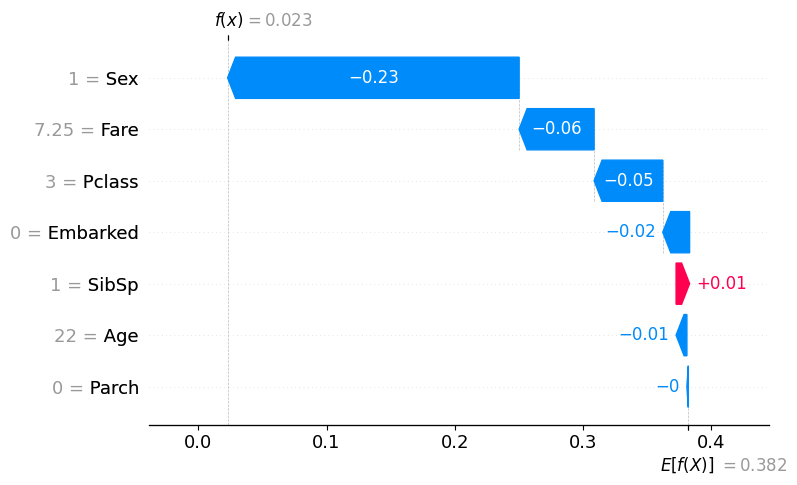

In [ ]:
model = xgboost.XGBRegressor().fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0])

According to the Shap waterfall plot, the feature variable with the highest amount of influence on the Target is Sex.  This means that the sex of a passenger has the greates effect on whether or not they survived.  After that, Fare and Pclass have the next largest impact, which makes sense since they are both indicators of socio-economic status.

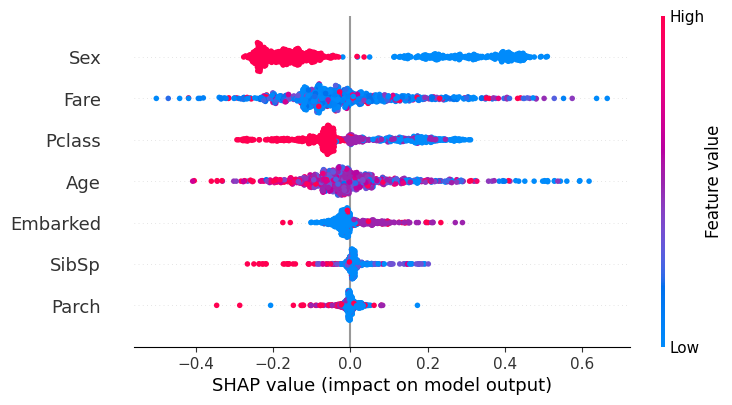

In [ ]:
shap.plots.beeswarm(shap_values)

This beeswarm plot offers a lot of insights into how the feature values affect whether or not the passengers survived.  First of all, the blue or "low" dots for sex represent female passengers, since they were encoded as 0.  On this plot, we can see that the blue dots are mostly on the right side, implying that the passengers' status as female have a strong positive impact on their odds of surviving.  We see a similar trend with Fare and Pclass as in the waterfall plot, where higher values for these features tend to result in a higher likelihood of survival.  Finally, one observation that is more visible here than in other plots is the affect of SibSp on the target value.  It seems as though a higher number of siblings is associated with a higher rate of survival, although this association is not as strong as the others.

[Text(0.5, 0.875, 'Sex <= 0.5\ngini = 0.472\nsamples = 711\nvalue = [439, 272]\nclass = Survived'),
 Text(0.25, 0.625, 'Pclass <= 2.5\ngini = 0.398\nsamples = 263\nvalue = [72, 191]\nclass = Not Survived'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Age <= 2.5\ngini = 0.092\nsamples = 144\nvalue = [7, 137]\nclass = Not Survived'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Fare <= 23.254\ngini = 0.496\nsamples = 119\nvalue = [65, 54]\nclass = Survived'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Fare <= 26.269\ngini = 0.296\nsamples = 448\nvalue = [367, 81]\nclass = Survived'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Age <= 10.0\ngini = 0.203\nsamples = 322\nvalue = [285, 37]\nclass = Survived'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'SibSp <= 2.5\ngini = 0.455\nsamples = 126\nvalue = [82, 44]\ncl

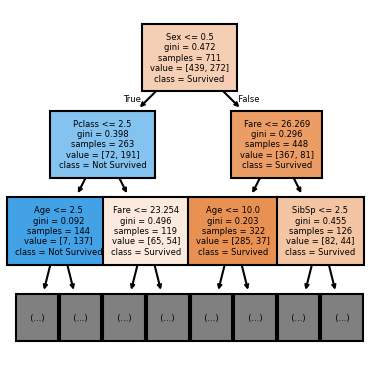

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(3,3), dpi=150)
plot_tree(model_dtree, fontsize=4, filled=True,
               max_depth=2,
               feature_names= df_features.columns,
               class_names= ['Survived','Not Survived'])

Above is a visualization of the first three layers of the decision tree that we created.  As you can see, the most influential feature on the target value is sex, with men being less likely to survive than women.  

After that, PClass and Fare are the features which play the largest role.  A lower value for PClass means a lower chance of survival, as seen on the left side of the second layer.  Similarly, a lower value for Fare also suggests a lower chance of survival.  

In exploratory analysis, we predicted that the most influential feature on the target value would be Sex, followed by PClass and Fare, so these results are very consistent with our exploratory analysis.

**Bias**

As previously discussed in exploratory analysis, the dataset contains a significantly greater number of male passengers than female passengers.  This could have an impact on the efficacy of the models, as they may be trained to perform better on male data than female data.  There are also a lot more non-survivors than survivors in the dataset, so this could limit a model's ability to accurately predict survivors.  

For example, there are 577 female data points, and only 312 male.  Additionally, of the 577 females, 231, or 40% survived, whereas only 109, or 35% of the men survived.  This discrepancy in representation mean that models built on this dataset would likely be less accurate when predicting whether or not a male were to survive.

**Conclusion**

There are many insights to be gained from the analysis of this data set.  First of all, through data exploration, we were able to ascertain multiple pieces of information about the data itself.  For example, most of the data is relatively balanced in its representation, with a few exceptions.  Sex is heavily biased in the favor of Male, and Embarked is heavily biased towards Southampton.  Furthermore, there are more non-survivors present in the target set than survivors.  

When building models, the patterns in the data became clear.  When determining whether or not a given passenger survived, the single most influential factor is their gender.  Females are much more likely to have survived according to this dataset.  Other factors with a high impact on whether or not a passenger survived are Pclass and Fare.  This is interesting, because both of these variables are directly tied to the socioeconomic status of the person that they describe.  Therefore, based on the models built, we can generally say that the passengers in this dataset with the highest chance of survival were the wealthier female passengers.

Although these insights are valuable, there is some bias in the data which makes it difficult to generalize our results to every passenger on the Titanic.  There are many more males in the data set than females, which would suggest that the model is better at predicting outcomes for male passengers than female.  This was confirmed using a classification report, in which a model trained on only male data performed poorly when tested on female data.  Additionally, there are a lot more non-survivors in the dataset than survivors, which likely means that the model is worse at predicting survivors.

In conclusion, this data set offers some valuable insight into the factors that influenced whether Titanic passengers survived, however a dataset with less bias would be necessary in order to say for certain exactly what the determinants are with full confidence.